In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime

import geopandas as gpd
from shapely.geometry import Point

# Seleção de um conjunto de usinas para treinamento dos modelos preditivos

Etapas:
- Leitura do conjunto de dados de geração de energia das usinas eólicas
- Determinação das usinas eólicas com maior geração média em cada estado
- Escolha de um conjunto eólico para a criação de modelos preditivos de geração

Conjunto eólico escolhido: Conjunto Eólico Umburanas, Bahia

### Geração de usinas eólicas individuais, de 2018 a 2023

In [2]:
# Lendo dados de geração em usinas eólicas
df_geracao_eolica = pd.read_csv(r"..\Dados tratados\ONS - FATOR_CAPACIDADE_2018-2023.csv")
df_geracao_eolica=df_geracao_eolica[df_geracao_eolica["nom_tipousina"]=="Eólica"]
df_geracao_eolica["din_instante"]=pd.to_datetime(df_geracao_eolica["din_instante"])

In [3]:
#df_geracao_eolica["geracao_programada_normalizada"]=df_geracao_eolica["val_geracaoprogramada"]/df_geracao_eolica["val_capacidadeinstalada"]
#df_geracao_eolica["geracao_verificada_normalizada"]=df_geracao_eolica["val_geracaoverificada"]/df_geracao_eolica["val_capacidadeinstalada"]
df_geracao_eolica=df_geracao_eolica[["din_instante","id_subsistema","id_estado","nom_modalidadeoperacao","nom_tipousina","nom_usina_conjunto",
                                     "id_ons","ceg","val_geracaoprogramada","val_geracaoverificada","val_capacidadeinstalada","val_fatorcapacidade"]]
df_geracao_eolica.head()

,din_instante,id_subsistema,id_estado,nom_modalidadeoperacao,nom_tipousina,nom_usina_conjunto,id_ons,ceg,val_geracaoprogramada,val_geracaoverificada,val_capacidadeinstalada,val_fatorcapacidade
0,2018-01-01 00:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,176.5,199.662,220.8,0.904266
1,2018-01-01 01:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,172.0,188.220,220.8,0.852446
2,2018-01-01 02:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,169.5,192.300,220.8,0.870924
3,2018-01-01 03:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,167.5,191.147,220.8,0.865702
4,2018-01-01 04:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,164.5,194.634,220.8,0.881495


In [4]:
df_geracao_eolica.drop(["val_fatorcapacidade"],axis=1,inplace=True)
df_geracao_eolica.head()

,din_instante,id_subsistema,id_estado,nom_modalidadeoperacao,nom_tipousina,nom_usina_conjunto,id_ons,ceg,val_geracaoprogramada,val_geracaoverificada,val_capacidadeinstalada
0,2018-01-01 00:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,176.5,199.662,220.8
1,2018-01-01 01:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,172.0,188.220,220.8
2,2018-01-01 02:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,169.5,192.300,220.8
3,2018-01-01 03:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,167.5,191.147,220.8
4,2018-01-01 04:00:00,N,MA,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,164.5,194.634,220.8


### Busca por um conjunto eólico para representar cada estado

In [5]:
# Determinando qual é a usina eólica com maior geração média em cada estado
# Fonte: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
df_geracao_eolica_media = df_geracao_eolica.groupby(["id_estado","nom_usina_conjunto"])["val_geracaoverificada"].agg("mean").reset_index()
df_geracao_eolica_media.sort_values(by="val_geracaoverificada",inplace=True,ascending=False)

df_geracao_eolica_maiores = df_geracao_eolica_media.groupby(["id_estado"])[["id_estado","nom_usina_conjunto","val_geracaoverificada"]].head(5)
df_geracao_eolica_maiores.sort_values(by=["id_estado","val_geracaoverificada"],inplace=True,ascending=[True,False])
df_geracao_eolica_maiores.head(80)

,id_estado,nom_usina_conjunto,val_geracaoverificada
33,BA,Conj. Morro do Chapéu Sul II,217.071367
50,BA,Conj. Umburanas,184.929431
15,BA,Conj. Campo Largo 2,166.412297
22,BA,Conj. Folha Larga,162.790036
26,BA,Conj. Gentio do Ouro I,154.046276
74,CE,Conj. Trairí,78.187904
71,CE,Conj. Serrote,77.021255
72,CE,Conj. Serrote A,74.692676
63,CE,Conj. Itarema V,74.462667
61,CE,Conj. Faísa,62.684621


In [6]:
# Armazenando os nomes das usinas com maior geração média em cada estado
# Fonte: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
d_usinas_eolicas = df_geracao_eolica_maiores.to_dict("records")
lista_usina_estados = [[d["nom_usina_conjunto"],d["id_estado"]] for d in d_usinas_eolicas]
lista_usinas = [item[0] for item in lista_usina_estados]
lista_estados = [item[1] for item in lista_usina_estados]
print(lista_usinas)

['Conj. Morro do Chapéu Sul II', 'Conj. Umburanas', 'Conj. Campo Largo 2', 'Conj. Folha Larga', 'Conj. Gentio do Ouro I', 'Conj. Trairí', 'Conj. Serrote', 'Conj. Serrote A', 'Conj. Itarema V', 'Conj. Faísa', 'Conj. Paulino Neves', 'Conj. Chafariz Sul II', 'Conj. Chafariz Norte', 'Conj. Serra do Seridó', 'Conj. Chafariz Sul I', 'Conj. São Clemente', 'Conj. Caetés II', 'Conj. Paranatama', 'Conj. Tacaratu II', 'Conj. Tacaratu (Eólico)', 'Conj. Lagoa dos Ventos', 'Conj. Araripe III', 'Conj. São Roque', 'Conj. Oitis', 'Conj. Lagoa dos Ventos 3', 'Conj. Rio do Vento', 'Conj. Serra do Mel', 'Conj. Monte Verde', 'Conj. Rio do Vento Expansão', 'Conj. Serra do Mel B', 'Conj. Santa Vitória do Palmar', 'Conj. Marmeleiro 2', 'Conj. Lagoa dos Barros', 'Conj. Cerro Chato', 'Conj. Atlântica', 'Conj. Água Doce', 'Conj. Bom Jardim']


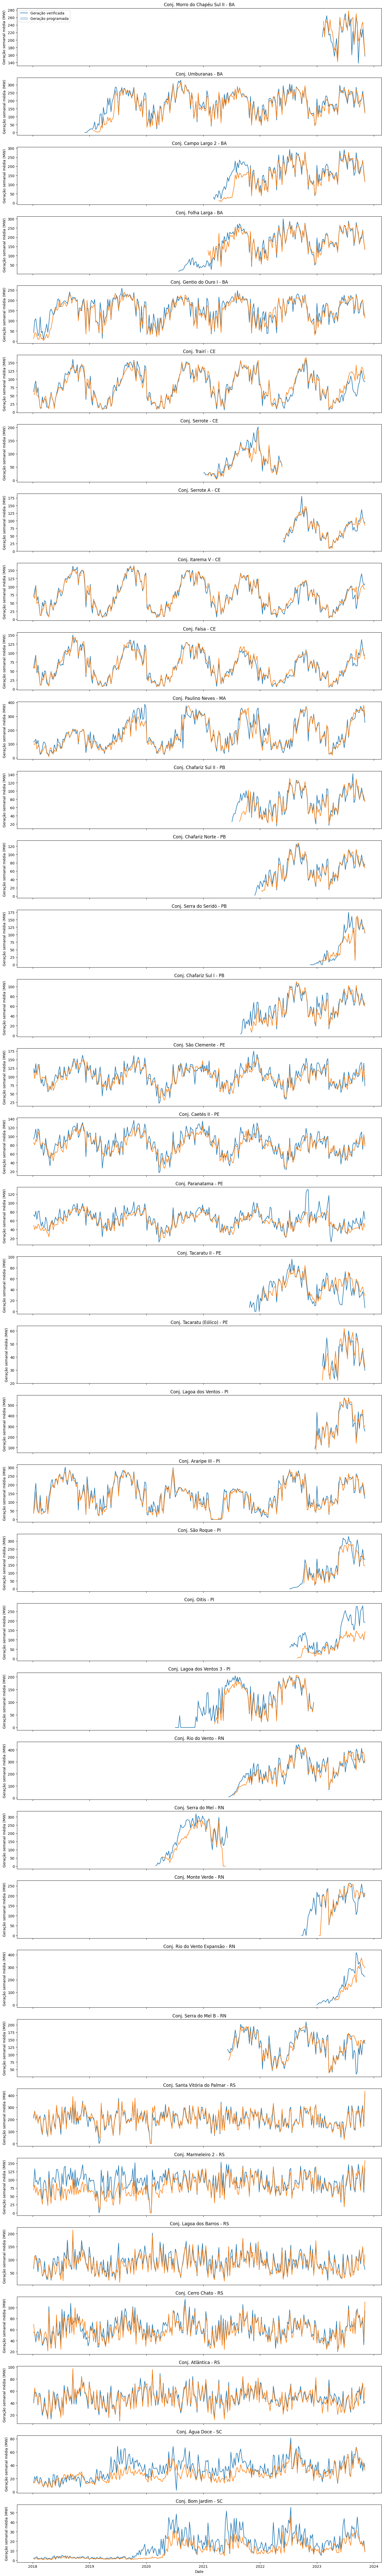

In [7]:
df_geracao_eolica_maiores=df_geracao_eolica[df_geracao_eolica["nom_usina_conjunto"].isin(lista_usinas)]
df_geracao_eolica_maiores=df_geracao_eolica_maiores.groupby(["id_estado","nom_usina_conjunto",pd.Grouper(key="din_instante",freq="W")])[["val_geracaoverificada","val_geracaoprogramada"]].agg("mean").reset_index()

n = len(lista_usinas)
fig, axes = plt.subplots(nrows = n, figsize=(15,100), sharex=True)

for i, usina in enumerate(lista_usinas):
    df = df_geracao_eolica_maiores[df_geracao_eolica_maiores["nom_usina_conjunto"]==usina]
    estado = lista_estados[i]
    eixo = axes[i]
    
    sns.lineplot(data=df, x="din_instante", y="val_geracaoverificada",ax=eixo);
    sns.lineplot(data=df, x="din_instante", y="val_geracaoprogramada",ax=eixo);
    
    if (i==0):
        eixo.legend(labels=["Geração verificada", "Geração programada"],loc="upper left")
    
    eixo.set_xlabel("Date")
    eixo.set_ylabel("Geração semanal média (MW)")
    eixo.set_title(usina + " - " + estado)
    
plt.tight_layout()
plt.show()
    

Dentre os conjuntos com a maior geração média de cada estado, o Conjunto Eólico Umuburanas, localizado no Estado da Bahia, foi selecionado para a etapa de treinamento de modelos de previsão da geração de energia.

In [8]:
lista_usinas = ['Conj. Umburanas',
                'Conj. Trairí',
                'Conj. Paulino Neves', 
                'Conj. Chafariz Sul II',
                'Conj. São Clemente', 
                'Conj. Araripe III',
                'Conj. Rio do Vento', 
                'Conj. Santa Vitória do Palmar',
                'Conj. Água Doce']

### Conjunto Umburanas - Bahia

#### Tratamento de dados e seleção de atributos para o treinamento de modelos preditivos

In [9]:
df_conj_BA = df_geracao_eolica[df_geracao_eolica["nom_usina_conjunto"]=="Conj. Umburanas"]
df_conj_BA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43104 entries, 2331634 to 2374737
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   din_instante             43104 non-null  datetime64[ns]
 1   id_subsistema            43104 non-null  object        
 2   id_estado                43104 non-null  object        
 3   nom_modalidadeoperacao   43104 non-null  object        
 4   nom_tipousina            43104 non-null  object        
 5   nom_usina_conjunto       43104 non-null  object        
 6   id_ons                   43104 non-null  object        
 7   ceg                      43104 non-null  object        
 8   val_geracaoprogramada    41784 non-null  float64       
 9   val_geracaoverificada    43104 non-null  float64       
 10  val_capacidadeinstalada  43104 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 3.9+ MB


In [10]:
df_conj_BA.columns = ["Data","Subsistema", "Estado", "Modalidade", "Tipo", "Nome", "ID ONS", "CEG", "Geração programada", "Geração verificada", "Capacidade instalada"]
df_conj_BA.head()

,Data,Subsistema,Estado,Modalidade,Tipo,Nome,ID ONS,CEG,Geração programada,Geração verificada,Capacidade instalada
2331634,2018-12-01 00:00:00,NE,BA,Conjunto de Usinas,Eólica,Conj. Umburanas,CJU_BAUBN,-,NaN,0.0,47.5
2331635,2018-12-01 01:00:00,NE,BA,Conjunto de Usinas,Eólica,Conj. Umburanas,CJU_BAUBN,-,NaN,0.0,47.5
2331636,2018-12-01 02:00:00,NE,BA,Conjunto de Usinas,Eólica,Conj. Umburanas,CJU_BAUBN,-,NaN,0.0,47.5
2331637,2018-12-01 03:00:00,NE,BA,Conjunto de Usinas,Eólica,Conj. Umburanas,CJU_BAUBN,-,NaN,0.0,47.5
2331638,2018-12-01 04:00:00,NE,BA,Conjunto de Usinas,Eólica,Conj. Umburanas,CJU_BAUBN,-,NaN,0.0,47.5


In [11]:
df_conj_BA=df_conj_BA[df_conj_BA["Data"].dt.year>=2021]
df_conj_BA=df_conj_BA.groupby(pd.Grouper(key="Data",freq="h"))[["Geração programada","Geração verificada"]].agg("mean").reset_index()
df_conj_BA_semana=df_conj_BA.groupby(pd.Grouper(key="Data",freq="W"))[["Geração programada","Geração verificada"]].agg("mean").reset_index()
df_conj_BA.head(20)

,Data,Geração programada,Geração verificada
0,2021-01-01 00:00:00,257.5,291.246
1,2021-01-01 01:00:00,234.5,297.211
2,2021-01-01 02:00:00,221.0,286.336
3,2021-01-01 03:00:00,206.0,266.143
4,2021-01-01 04:00:00,187.5,262.873
5,2021-01-01 05:00:00,171.0,246.994
6,2021-01-01 06:00:00,163.5,222.862
7,2021-01-01 07:00:00,163.5,254.567
8,2021-01-01 08:00:00,161.0,221.275
9,2021-01-01 09:00:00,136.0,139.679


In [12]:
df_conj_BA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24816 entries, 0 to 24815
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Data                24816 non-null  datetime64[ns]
 1   Geração programada  24816 non-null  float64       
 2   Geração verificada  24816 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 581.8 KB


In [13]:
# Source for the transformation: Feature Engineering for Time Series Forecasting, https://www.trainindata.com/
df_conj_BA["Data"] = pd.to_datetime(df_conj_BA["Data"], format="%Y-%m-%d %H:%M:%S")
df_conj_BA = df_conj_BA.set_index("Data")
df_conj_BA.sort_index(inplace=True)
df_conj_BA = df_conj_BA.asfreq("1h", method = "ffill")
df_conj_BA.head(20)

,Geração programada,Geração verificada
Data,,
2021-01-01 00:00:00,257.5,291.246
2021-01-01 01:00:00,234.5,297.211
2021-01-01 02:00:00,221.0,286.336
2021-01-01 03:00:00,206.0,266.143
2021-01-01 04:00:00,187.5,262.873
2021-01-01 05:00:00,171.0,246.994
2021-01-01 06:00:00,163.5,222.862
2021-01-01 07:00:00,163.5,254.567
2021-01-01 08:00:00,161.0,221.275


In [14]:
df_conj_BA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2021-01-01 00:00:00 to 2023-10-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Geração programada  24816 non-null  float64
 1   Geração verificada  24816 non-null  float64
dtypes: float64(2)
memory usage: 581.6 KB


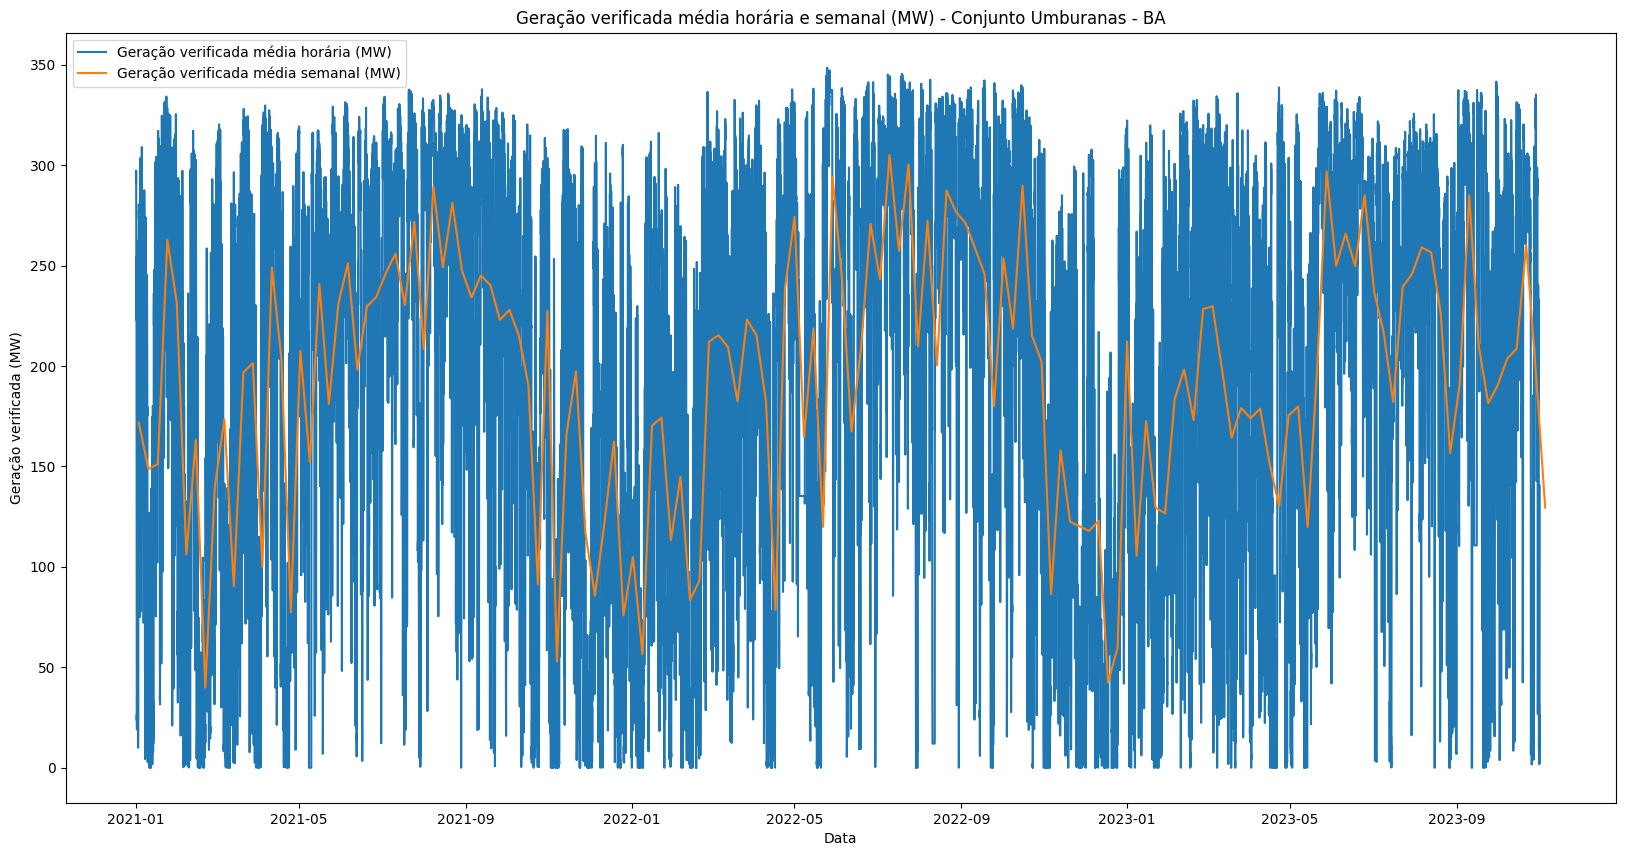

In [15]:
fig, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_conj_BA, x="Data", y="Geração verificada",ax=axes, label="Geração verificada média horária (MW)");
sns.lineplot(data=df_conj_BA_semana, x="Data", y="Geração verificada",ax=axes, label="Geração verificada média semanal (MW)");
axes.set_ylabel("Geração verificada (MW)");
axes.set_title("Geração verificada média horária e semanal (MW) - Conjunto Umburanas - BA");
axes.legend();

In [16]:
# Fazendo a leitura dos dados meteorológicos associados ao Conjunto Umburanas
df_tempo = pd.read_csv(r"..\Dados tratados\tempo - umburanas-ba.csv")
df_tempo.head()

,data_hora,temperatura,velocidade_vento,direcao_vento
0,2021-01-01 00:00:00,20.5,23.2,83
1,2021-01-01 01:00:00,19.9,26.3,100
2,2021-01-01 02:00:00,18.9,25.6,92
3,2021-01-01 03:00:00,18.2,25.6,92
4,2021-01-01 04:00:00,17.9,24.5,93


Notas:

- A coordenada utilizada na chamada à API de dados meteorológicos não corresponde exatamente ao centróide das coordenadas dos geradores eólicos do conjunto Umburanas.
- A distância entre os geradores eólicos e a coordenada escolhida varia de 3.5 km e 7.5 km, aproximadamente. Isto só foi percebido pelo autor do estudo após a conclusão do treinamento dos modelos de previsão. O ideal teria sido selecionar um ponto mais próximo aos geradores para diminuir o erro de estimação da velocidade do vento.

In [17]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24840 entries, 0 to 24839
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_hora         24840 non-null  object 
 1   temperatura       24840 non-null  float64
 2   velocidade_vento  24840 non-null  float64
 3   direcao_vento     24840 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 776.4+ KB


In [18]:
# Fonte para a formatação a seguir: Feature Engineering for Time Series Forecasting, https://www.trainindata.com/
df_tempo["data_hora"] = pd.to_datetime(df_tempo["data_hora"], format="%Y-%m-%d %H:%M:%S")
df_tempo = df_tempo.set_index("data_hora")
df_tempo.sort_index(inplace=True)
df_tempo = df_tempo.asfreq("1h", method = "ffill")
df_tempo.head(20)

,temperatura,velocidade_vento,direcao_vento
data_hora,,,
2021-01-01 00:00:00,20.5,23.2,83
2021-01-01 01:00:00,19.9,26.3,100
2021-01-01 02:00:00,18.9,25.6,92
2021-01-01 03:00:00,18.2,25.6,92
2021-01-01 04:00:00,17.9,24.5,93
2021-01-01 05:00:00,17.9,24.2,93
2021-01-01 06:00:00,18.2,24.2,94
2021-01-01 07:00:00,19.4,24.9,92
2021-01-01 08:00:00,21.0,24.1,91


In [19]:
# Agrupando os dados de geração com os dados meteorológicos para o Conjunto Eólico Umburanas
df_conj_BA = df_conj_BA.join(df_tempo, how = "left")
df_conj_BA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2021-01-01 00:00:00 to 2023-10-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Geração programada  24816 non-null  float64
 1   Geração verificada  24816 non-null  float64
 2   temperatura         24816 non-null  float64
 3   velocidade_vento    24816 non-null  float64
 4   direcao_vento       24816 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.6 MB


In [20]:
# Salvando os dados para utilização no treinamento de modelos preditivos
df_conj_BA.to_csv(r"..\Dados tratados\geracao e tempo - umburanas-ba.csv", encoding = "utf-8", index=True)